# Importación de librerías

In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pyzbar.pyzbar import decode

# Lectura de imagen

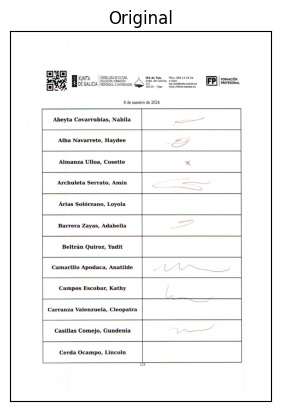

In [53]:
# Leemos la imagen original con la que trabajaremos
img = cv2.imread('src/Escaneo.jpg')
# img = cv2.imread('src/Escaneo0001.jpg')
plt.subplot(1,1,1),plt.imshow(img,'gray')
plt.title('Original')
plt.xticks([]),plt.yticks([])
plt.show()

# Obtención de información del QR

In [54]:
def leer_QR(imagen_original):
    codigos_qr = decode(imagen_original)

    for codigo_qr in codigos_qr:
        datos_qr = codigo_qr.data.decode('utf-8')
        paginas, fecha = datos_qr.split('-',1)
        print(f'Páginas: {paginas}')
        print(f'Fecha: {fecha}')

In [55]:
leer_QR(img)

Páginas: 1/3
Fecha: 2024-01-08


# Obtención de contorno grande

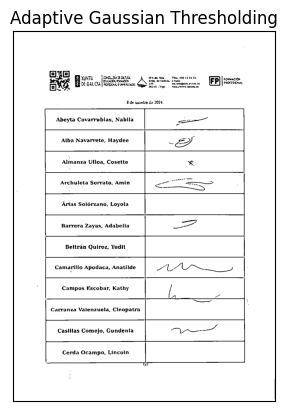

In [56]:
blurMedian = cv2.medianBlur(img,5)
blurMedian_gray = cv2.cvtColor(blurMedian, cv2.COLOR_BGR2GRAY)
umbral = cv2.adaptiveThreshold(blurMedian_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)


plt.subplot(1,1,1),plt.imshow(umbral,'gray')
plt.title('Adaptive Gaussian Thresholding')
plt.xticks([]),plt.yticks([])
plt.show()

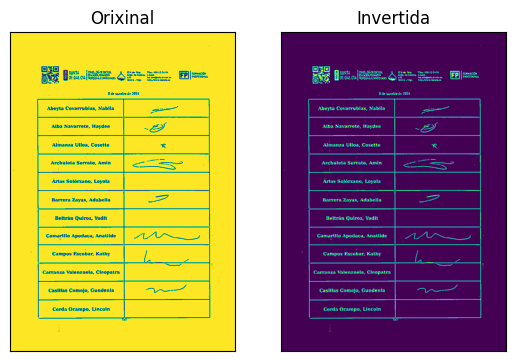

In [57]:
img_invertida = cv2.bitwise_not(umbral)

plt.subplot(121),plt.imshow(umbral),plt.title('Orixinal')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_invertida),plt.title('Invertida')
plt.xticks([]), plt.yticks([])
plt.show()

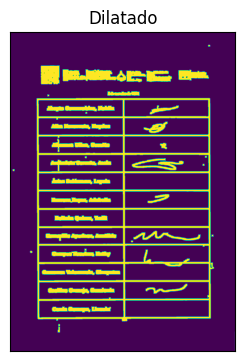

In [58]:
kernel = np.ones((5,5),np.uint8)
img_dilatada = cv2.dilate(img_invertida,kernel,iterations = 2)
plt.subplot(122),plt.imshow(img_dilatada),plt.title('Dilatado')
plt.xticks([]), plt.yticks([])
plt.show()

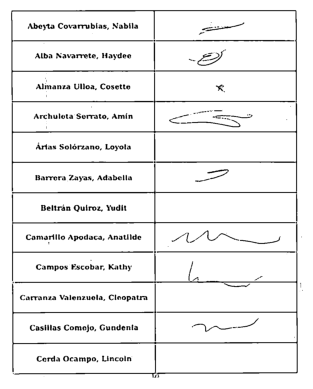

In [59]:
# Detectamos los contornos
contornos, jerarquia = cv2.findContours(img_dilatada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenamos la lista de contornos
contornos = sorted(contornos, key=cv2.contourArea, reverse=True)

# Cogemos el primer contorno de la lista ya que el que nos interesa es el de mayor tamaño
contorno_mas_grande = contornos[0]

x, y, w, h = cv2.boundingRect(contorno_mas_grande)

rectangulo_principal = umbral[y:y+h, x:x+w]

plt.imshow(rectangulo_principal, cmap='gray')
plt.axis('off')
plt.show()

# División en dos del rectángulo principal

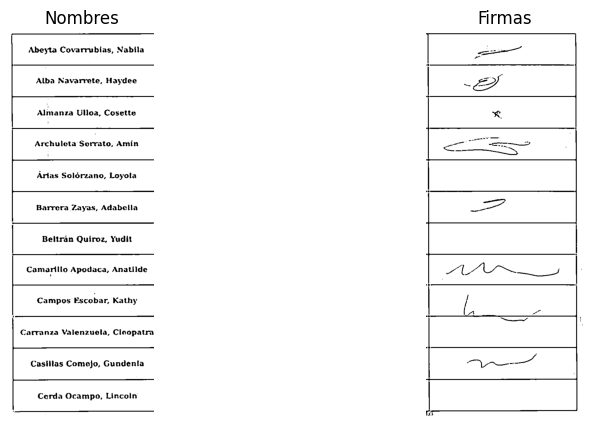

In [60]:
# Dividimos el rectángulo principal en dos partes
mitad_ancho = w // 2

# Mitad izquierda (para sacar la información de los nombres). Le restamos ahí para que a la hora de coger los nombres no entren en conflicto.
izquierda = rectangulo_principal[:, :mitad_ancho - 30]


# Mitad derecha (para sacar si han hecho firma o no). En este caso, necesitaremos que tenga el borde para que a la hora de reconocer los contornos no haya problemas.
derecha = rectangulo_principal[:, mitad_ancho - 15:]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(izquierda, cmap='gray'), plt.title('Nombres'), plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(derecha, cmap='gray'), plt.title('Firmas'), plt.axis('off')
plt.show()

# Lista con los nombres de la columna de la izquierda

In [61]:
import pytesseract
import os

# Especificamos la ubicación del ejecutable de Tesseract OCR
pytesseract.pytesseract.tesseract_cmd = r'/home/a23brunoad/miniconda3/envs/clase/bin/tesseract'

# Establecemos la variable de entorno TESSDATA_PREFIX
os.environ['TESSDATA_PREFIX'] = '/home/a23brunoad/miniconda3/envs/clase/share/tessdata'

texto_izquierda = pytesseract.image_to_string(izquierda)

# Extraemos los nombres de la parte izquierda y eliminamos las cadenas vacías
lista_nombres = [nombre for nombre in texto_izquierda.split('\n') if nombre.strip()]

print(lista_nombres)

['Abeyta Covarrubias, Nabila', 'Alba Navarrete, Haydeo', 'Alianza Ulloa, Cosette', 'Archulota Sorrato, Amin', 'Artas Solérzano, Loyola', 'Barrora Zayas, Adabella', 'Beltran Quiroz, Yudit', 'Camarillo Apodaca, Anatilde', 'Campos Escobar, Kathy', 'Carranza Valenzuela, Cloopatra', 'Casillas Comejo, Gundenta', 'Cerda Ocampo, Lincoln']


# Lista de comprobación si está firmada la casilla o no

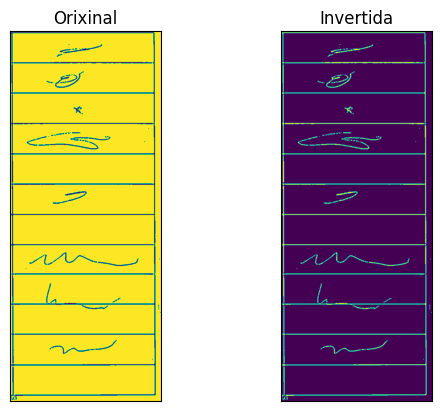

In [62]:
img_invertida_derecha = cv2.bitwise_not(derecha)

plt.subplot(121),plt.imshow(derecha),plt.title('Orixinal')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_invertida_derecha),plt.title('Invertida')
plt.xticks([]), plt.yticks([])
plt.show()

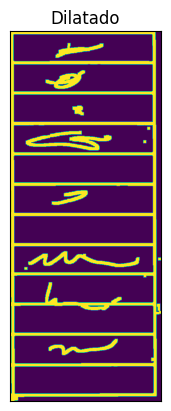

In [63]:
kernel_derecha = np.ones((5,5),np.uint8)
img_dilatada_derecha = cv2.dilate(img_invertida_derecha,kernel,iterations = 2)
plt.subplot(122),plt.imshow(img_dilatada_derecha),plt.title('Dilatado')
plt.xticks([]), plt.yticks([])
plt.show()

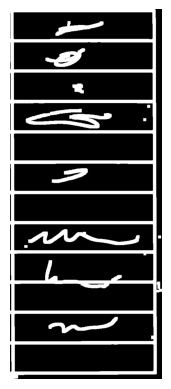

In [64]:
# Detectamos los contornos
contornos_derecha, jerarquia = cv2.findContours(img_dilatada_derecha, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenamos la lista de contornos
contornos_derecha = sorted(contornos_derecha, key=cv2.contourArea, reverse=True)

# Cogemos el primer contorno de la lista ya que el que nos interesa es el de mayor tamaño
contorno_mayor_derecha = contornos_derecha[0]

x, y, w, h = cv2.boundingRect(contorno_mayor_derecha)

rectangulo_principal_derecha = img_dilatada_derecha[y:y+h, x:x+w]

plt.imshow(rectangulo_principal_derecha, cmap='gray')
plt.axis('off')
plt.show()

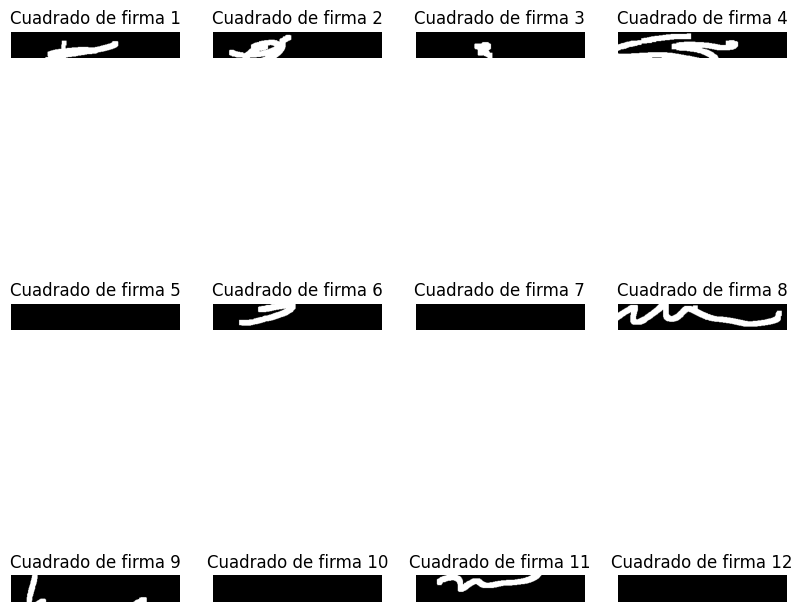

In [65]:
# Dividimos el rectángulo principal en 12 partes para el alto
division_alto = h // 12

# Almacenamos las partes
firmas = []

for i in range(12):
    # Calculamos las coordenadas
    inicio = i * division_alto
    fin = (i + 1) * division_alto

    # Recortamos la parte
    parte = rectangulo_principal_derecha[inicio:fin, :]
    firmas.append(parte)

# Inicializamos la lista para almacenar los cuadrados de cada firma
lista_cuadrados_firmas = []

# Inicializamos la lista para almacenar los resultados de la verificación de contornos
resultados = []

for i in range(len(firmas)):
    # Definimos las coordenadas
    inicio_x = int(firmas[i].shape[1] // 6)
    inicio_y = int(firmas[i].shape[0] // 5)
    fin_x = int(firmas[i].shape[1] * 3.5 // 4)
    fin_y = int(firmas[i].shape[0] * 3 // 4)

    # Recortamos la región de interés
    cuadrado_firma = firmas[i][inicio_y:fin_y, inicio_x:fin_x]

    # Añadimos el recorte a la lista
    lista_cuadrados_firmas.append(cuadrado_firma)

    # Verificamos si hay contornos en la región de interés
    _, binaria = cv2.threshold(cuadrado_firma, 0, 255, cv2.THRESH_BINARY)
    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contornos) > 0:
        resultados.append('Si ha firmado')
    else:
        resultados.append('No ha firmado')

# Mostramos visualmente los cuadrados de firma
plt.figure(figsize=(10, 10))
for idx, (cuadrado_firma, resultado) in enumerate(zip(lista_cuadrados_firmas, resultados)):
    plt.subplot(3, 4, idx+1)
    plt.imshow(cuadrado_firma, cmap='gray')
    plt.title(f'Cuadrado de firma {idx+1}')
    plt.axis('off')
plt.show()

In [66]:
# Creamos el diccionario con las dos listas
diccionario_final = dict(zip(lista_nombres, resultados))

for nombre,firma in diccionario_final.items():
    print(f'Nombre: {nombre}. \n\tFirma?: {firma}')

Nombre: Abeyta Covarrubias, Nabila. 
	Firma?: Si ha firmado
Nombre: Alba Navarrete, Haydeo. 
	Firma?: Si ha firmado
Nombre: Alianza Ulloa, Cosette. 
	Firma?: Si ha firmado
Nombre: Archulota Sorrato, Amin. 
	Firma?: Si ha firmado
Nombre: Artas Solérzano, Loyola. 
	Firma?: No ha firmado
Nombre: Barrora Zayas, Adabella. 
	Firma?: Si ha firmado
Nombre: Beltran Quiroz, Yudit. 
	Firma?: No ha firmado
Nombre: Camarillo Apodaca, Anatilde. 
	Firma?: Si ha firmado
Nombre: Campos Escobar, Kathy. 
	Firma?: Si ha firmado
Nombre: Carranza Valenzuela, Cloopatra. 
	Firma?: No ha firmado
Nombre: Casillas Comejo, Gundenta. 
	Firma?: Si ha firmado
Nombre: Cerda Ocampo, Lincoln. 
	Firma?: No ha firmado
